In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

!pip install sentencepiece
import torch
import torch.nn as nn
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
from sklearn import metrics
import os
import matplotlib.pyplot as plt
import re
import pickle
from google.colab import drive
import sys

drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/nlp-punctuation/punctuation-project')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from model import Model, load_weights
from solver import Solver, define_parser, initialize_model_and_components
from prepare_data import DatasetText, DatasetTextProcessor, custom_collate_fn
from read_data import create_data_book, load_text_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.7 MB/s eta 0:00:00
Mounted at /content/gdrive


# Prepare data

In [2]:
parser = define_parser()

# Simulate command-line arguments in a notebook
args = parser.parse_args([

    # loading and preparing data
    "--books_dir", "/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/gutenberg_data/txt",
    "--save_data_dir", "/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/gutenberg_data",
    "--num_workers", "8",
    "--train_size", "300000",
    "--valid_size", "30000",
    "--test_size", "30000",

    # training model
    "--epochs", "1",
    "--batch_size_train", "16",
    "--batch_size_test", "64",
    "--log_steps", "1000",
    "--classes", ".,:!?",
    "--lr", "0.000005",
    "--save_training_dir", "/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base",
    "--model_save_name", "deberta-v3-base-tokens",
    "--pretrained_model", 'microsoft/deberta-v3-base', #'roberta-base'

    # loading checkpoint model
    #"--load_model", "/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-tokens/model_deberta-v3-tokens_last.pth"
    ])



The used dataset is created based on ~3000 books from the gutenberg corpus. First of all, I create a train, test and dev dataset from a random subset of the data. The size of the dataset could be expanded but I am limited by the computational ressources. The dev set may or may not be used later.

In [ ]:
# create train valid test splits of the data
train_text, valid_text, test_text = create_data_book(args, save=True)

now that the files got created once, they can be loaded from the save directory

In [3]:
# load the train valid test datasets
train_text, valid_text, test_text  = load_text_data(args)

# Dataset Overview
here the counts of the tokens are obtained for the dataset

In [ ]:
# define model save dir
args.pretrained_model = 'microsoft/deberta-v3-base'

In [ ]:
model = Model(args)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [ ]:
def count_labels(labels, counts_total):
    # capitalization
    unique_items, counts = torch.unique(labels, return_counts=True)
    # Create a dictionary to store the results
    label_dict = {item.item(): count.item() for item, count in zip(unique_items, counts)}

    for key, item in label_dict.items():

      if key not in counts_total.keys():
        counts_total[key] = item
      else:
        counts_total[key] += item

    return counts_total

In [ ]:
# get word and token counts for the dataset
datasets = {'train': train_text, 'valid': valid_text, 'test': test_text}

results = {}

for key, data in datasets.items():

    dataset = DatasetTextProcessor(data, args.classes, model.tokenizer)
    dl = DataLoader(dataset, batch_size = args.batch_size_train, shuffle=True, collate_fn=custom_collate_fn, num_workers=args.num_workers)

    word_count = 0
    token_count = 0
    punc_counts_total = {}
    cap_counts_total = {}

    for encoding, word_ids, labels in tqdm(dl):

      token_count += torch.sum(~torch.isnan(word_ids)).item()
      word_ids[torch.isnan(word_ids)] = -100
      word_count += (word_ids.max(dim=1).values+1).sum().item()

      cap_counts_total = count_labels(labels[:,:,0], cap_counts_total)
      punc_counts_total = count_labels(labels[:,:,1], punc_counts_total)


    results[key] = {'words': word_count, 'tokens': token_count, 'cap_labels': cap_counts_total, 'punc_labels': punc_counts_total}

results['train']['chunks']=len(train_text)
results['valid']['chunks']=len(test_text)
results['test']['chunks']=len(valid_text)

100%|██████████| 1875/1875 [00:33<00:00, 56.75it/s]


In [ ]:
df = pd.DataFrame.from_dict(results, orient='index')
df = df.reset_index()
df = df.rename(columns={'index': 'Split'})

# Flatten the nested dictionaries
df = pd.concat([df.drop(['cap_labels', 'punc_labels'], axis=1), df['cap_labels'].apply(pd.Series), df['punc_labels'].apply(pd.Series)], axis=1)

In [ ]:
df = pd.DataFrame.from_dict(results, orient='index')
df.index.name = 'Split'

# Flatten the nested dictionaries
df = pd.concat([df.drop(['cap_labels', 'punc_labels'], axis=1),
                df['cap_labels'].apply(lambda x: {'LOWERCASE': x[0], 'UPPERCASE': x[1]}),
                df['punc_labels'].apply(lambda x: {'NONE': x[0], 'PERIOD': x[1], 'COMMA': x[2], 'COLON': x[3], 'EXCLAMATION': x[4], 'QUESTION': x[5]})], axis=1)
df = pd.concat([df.drop(['cap_labels', 'punc_labels'], axis=1), df['cap_labels'].apply(pd.Series), df['punc_labels'].apply(pd.Series)], axis=1)

df = df.drop(columns=['LOWERCASE', 'NONE']).astype(int)

In [ ]:
df

,words,tokens,chunks,UPPERCASE,PERIOD,COMMA,COLON,EXCLAMATION,QUESTION
Split,,,,,,,,,
train,114037600,129054075,300000,11909117,5354785,8955566,191661,389252,435941
valid,11406828,12913272,30000,1197158,537997,895184,19020,38771,43916
test,11403627,12907347,30000,1192134,536941,896879,18886,38575,43514


In [ ]:
print(df.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &      words &     tokens &  chunks &  UPPERCASE &   PERIOD &    COMMA &   COLON &  EXCLAMATION &  QUESTION \\
Split &            &            &         &            &          &          &         &              &           \\
\midrule
train &  114037600 &  129054075 &  300000 &   11909117 &  5354785 &  8955566 &  191661 &       389252 &    435941 \\
valid &   11406828 &   12913272 &   30000 &    1197158 &   537997 &   895184 &   19020 &        38771 &     43916 \\
test  &   11403627 &   12907347 &   30000 &    1192134 &   536941 &   896879 &   18886 &        38575 &     43514 \\
\bottomrule
\end{tabular}



<ipython-input-163-eff2c52faac5>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


# DeBERTa V3 

## Predict Capitalization and Punctuation

In [8]:
# define model save dir
args.pretrained_model = 'microsoft/deberta-v3-base'
args.model_save_name = 'model_deberta-v3-tokens'
args.save_training_dir = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base'
args.load_model =  'None'

solver = initialize_model_and_components(args)
ds_train = DatasetTextProcessor(train_text, args.classes, solver.model.tokenizer, mapping_tokens=True)
dl_train = DataLoader(ds_train, batch_size=args.batch_size_train, shuffle=True, collate_fn=custom_collate_fn, num_workers=args.num_workers)
ds_test = DatasetTextProcessor(test_text, args.classes, solver.model.tokenizer, mapping_tokens=True, return_overflowing_tokens=True)
dl_test = DataLoader(ds_test, batch_size=args.batch_size_train, shuffle=False, collate_fn=custom_collate_fn, num_workers=args.num_workers)

### Training

  0%|          | 0/100 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d72955c0ee0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d72955c0ee0>Traceback (most recent call last):
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d72955c0ee0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d72955c0ee0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d72955c0ee0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d72955c0ee0>Exception ignored in: Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__


Traceback (most recent call last):
    Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ 

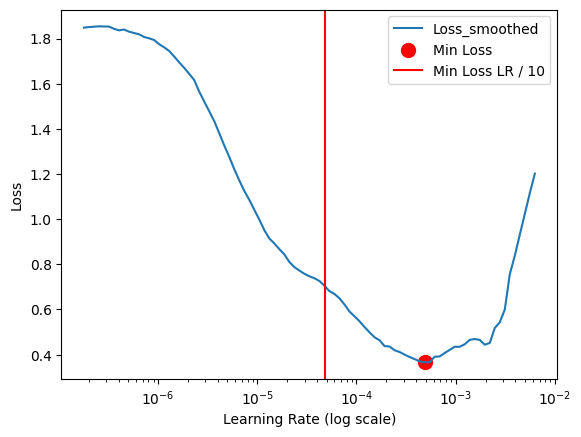

4.862601580065351e-05

In [ ]:
solver.find_lr(dl_train, init_lr=1e-7, final_lr=0.01, n_steps=100, show_plot=True)

In [ ]:
solver.train(dl=dl_train, lr=6*10**-6)

  0%|          | 0/18750 [00:00<?, ?it/s]

Iteration 0: average loss: 2.5010
             precision    recall  f1_score
UPPERCASE     0.151923  0.216142  0.178430
PERIOD        0.024858  0.166090  0.043243
COMMA         0.072478  0.134545  0.094208
COLON         0.000970  0.166667  0.001929
EXCLAMATION   0.000000  0.000000  0.000000
QUESTION      0.004912  0.312500  0.009671
mean          0.042523  0.165991  0.054580


  5%|▌         | 1000/18750 [05:42<1:40:25,  2.95it/s]

Iteration 1000: average loss: 0.3326
             precision    recall  f1_score
UPPERCASE     0.894640  0.803987  0.846894
PERIOD        0.757098  0.879121  0.813559
COMMA         0.676856  0.722611  0.698985
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.000000  0.000000  0.000000
QUESTION      1.000000  0.058824  0.111111
mean          0.554766  0.410757  0.411758


 11%|█         | 2000/18750 [11:21<1:34:07,  2.97it/s]

Iteration 2000: average loss: 0.2003
             precision    recall  f1_score
UPPERCASE     0.900391  0.863296  0.881453
PERIOD        0.815789  0.889344  0.850980
COMMA         0.808463  0.708984  0.755463
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.000000  0.000000  0.000000
QUESTION      0.727273  0.615385  0.666667
mean          0.541986  0.512835  0.525761


 16%|█▌        | 3000/18750 [17:02<1:29:04,  2.95it/s]

Iteration 3000: average loss: 0.1783
             precision    recall  f1_score
UPPERCASE     0.888710  0.898858  0.893755
PERIOD        0.818182  0.915789  0.864238
COMMA         0.774194  0.722222  0.747305
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.333333  0.047619  0.083333
QUESTION      0.800000  0.640000  0.711111
mean          0.602403  0.537415  0.549957


 21%|██▏       | 4000/18750 [22:43<1:23:13,  2.95it/s]

Iteration 4000: average loss: 0.1684
             precision    recall  f1_score
UPPERCASE     0.934066  0.898792  0.916089
PERIOD        0.883436  0.926045  0.904239
COMMA         0.787368  0.734774  0.760163
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.562500  0.473684  0.514286
QUESTION      0.750000  0.857143  0.800000
mean          0.652895  0.648406  0.649129


 27%|██▋       | 5000/18750 [28:23<1:17:33,  2.95it/s]

Iteration 5000: average loss: 0.1632
             precision    recall  f1_score
UPPERCASE     0.924296  0.903614  0.913838
PERIOD        0.872964  0.933798  0.902357
COMMA         0.823028  0.786151  0.804167
COLON         1.000000  0.166667  0.285714
EXCLAMATION   0.526316  0.270270  0.357143
QUESTION      0.740741  0.714286  0.727273
mean          0.814557  0.629131  0.665082


 32%|███▏      | 6000/18750 [34:04<1:11:58,  2.95it/s]

Iteration 6000: average loss: 0.1568
             precision    recall  f1_score
UPPERCASE     0.921440  0.859542  0.889415
PERIOD        0.884746  0.887755  0.886248
COMMA         0.750524  0.819222  0.783370
COLON         0.000000  0.000000  0.000000
EXCLAMATION   1.000000  0.352941  0.521739
QUESTION      0.777778  0.777778  0.777778
mean          0.722415  0.616206  0.643092


 37%|███▋      | 7000/18750 [39:45<1:06:22,  2.95it/s]

Iteration 7000: average loss: 0.1531
             precision    recall  f1_score
UPPERCASE     0.925191  0.942457  0.933744
PERIOD        0.871951  0.916667  0.893750
COMMA         0.756356  0.818807  0.786344
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.200000  0.062500  0.095238
QUESTION      0.700000  0.656250  0.677419
mean          0.575583  0.566114  0.564416


 43%|████▎     | 8000/18750 [45:26<1:00:39,  2.95it/s]

Iteration 8000: average loss: 0.1516
             precision    recall  f1_score
UPPERCASE     0.929624  0.869832  0.898734
PERIOD        0.845614  0.892593  0.868468
COMMA         0.796569  0.764706  0.780312
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.555556  0.344828  0.425532
QUESTION      0.722222  0.812500  0.764706
mean          0.641597  0.614076  0.622959


 48%|████▊     | 9000/18750 [51:06<55:05,  2.95it/s]

Iteration 9000: average loss: 0.1495
             precision    recall  f1_score
UPPERCASE     0.935043  0.923986  0.929482
PERIOD        0.881720  0.894545  0.888087
COMMA         0.816377  0.758065  0.786141
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.666667  0.421053  0.516129
QUESTION      0.724138  0.777778  0.750000
mean          0.670657  0.629238  0.644973


 53%|█████▎    | 10000/18750 [56:47<49:23,  2.95it/s]

Iteration 10000: average loss: 0.1468
             precision    recall  f1_score
UPPERCASE     0.913765  0.935484  0.924497
PERIOD        0.873646  0.899628  0.886447
COMMA         0.829569  0.832990  0.831276
COLON         0.600000  0.750000  0.666667
EXCLAMATION   0.583333  0.388889  0.466667
QUESTION      0.857143  0.571429  0.685714
mean          0.776243  0.729737  0.743544


 59%|█████▊    | 11000/18750 [1:02:28<43:42,  2.96it/s]

Iteration 11000: average loss: 0.1417
             precision    recall  f1_score
UPPERCASE     0.941667  0.882812  0.911290
PERIOD        0.919732  0.904605  0.912106
COMMA         0.833693  0.805846  0.819533
COLON         1.000000  0.333333  0.500000
EXCLAMATION   0.625000  0.526316  0.571429
QUESTION      0.925926  0.781250  0.847458
mean          0.874336  0.705694  0.760303


 64%|██████▍   | 12000/18750 [1:08:08<38:02,  2.96it/s]

Iteration 12000: average loss: 0.1440
             precision    recall  f1_score
UPPERCASE     0.906822  0.920608  0.913663
PERIOD        0.823529  0.908397  0.863884
COMMA         0.819172  0.791579  0.805139
COLON         1.000000  0.125000  0.222222
EXCLAMATION   0.600000  0.333333  0.428571
QUESTION      0.727273  0.695652  0.711111
mean          0.812799  0.629095  0.657432


 69%|██████▉   | 13000/18750 [1:13:49<32:25,  2.96it/s]

Iteration 13000: average loss: 0.1423
             precision    recall  f1_score
UPPERCASE     0.903120  0.894309  0.898693
PERIOD        0.854985  0.889937  0.872111
COMMA         0.827648  0.811620  0.819556
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.363636  0.266667  0.307692
QUESTION      0.870968  0.729730  0.794118
mean          0.636726  0.598710  0.615362


 75%|███████▍  | 14000/18750 [1:19:30<26:50,  2.95it/s]

Iteration 14000: average loss: 0.1388
             precision    recall  f1_score
UPPERCASE     0.912088  0.855670  0.882979
PERIOD        0.862676  0.884477  0.873440
COMMA         0.776087  0.774403  0.775244
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.571429  0.200000  0.296296
QUESTION      0.833333  0.606061  0.701754
mean          0.659269  0.553435  0.588286


 80%|████████  | 15000/18750 [1:25:11<21:09,  2.95it/s]

Iteration 15000: average loss: 0.1392
             precision    recall  f1_score
UPPERCASE     0.896000  0.860215  0.877743
PERIOD        0.861017  0.849498  0.855219
COMMA         0.777518  0.811736  0.794258
COLON         0.222222  0.400000  0.285714
EXCLAMATION   0.285714  0.222222  0.250000
QUESTION      0.782609  0.900000  0.837209
mean          0.637513  0.673945  0.650024


 85%|████████▌ | 16000/18750 [1:30:51<15:31,  2.95it/s]

Iteration 16000: average loss: 0.1371
             precision    recall  f1_score
UPPERCASE     0.940741  0.944238  0.942486
PERIOD        0.871212  0.954357  0.910891
COMMA         0.853488  0.758264  0.803063
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.750000  0.391304  0.514286
QUESTION      1.000000  0.812500  0.896552
mean          0.735907  0.643444  0.677880


 91%|█████████ | 17000/18750 [1:36:32<09:51,  2.96it/s]

Iteration 17000: average loss: 0.1375
             precision    recall  f1_score
UPPERCASE     0.933908  0.923295  0.928571
PERIOD        0.889518  0.928994  0.908828
COMMA         0.868750  0.794286  0.829851
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.636364  0.388889  0.482759
QUESTION      0.804878  0.804878  0.804878
mean          0.688903  0.640057  0.659148


 96%|█████████▌| 18000/18750 [1:42:12<04:13,  2.95it/s]

Iteration 18000: average loss: 0.1388
             precision    recall  f1_score
UPPERCASE     0.944742  0.899830  0.921739
PERIOD        0.871212  0.909091  0.889749
COMMA         0.805616  0.819780  0.812636
COLON         0.600000  0.166667  0.260870
EXCLAMATION   0.545455  0.545455  0.545455
QUESTION      1.000000  0.700000  0.823529
mean          0.794504  0.673470  0.708996


  0%|          | 0/18750 [00:00<?, ?it/s]

Iteration 0: average loss: 0.1345
             precision    recall  f1_score
UPPERCASE     0.954939  0.885852  0.919099
PERIOD        0.880878  0.915309  0.897764
COMMA         0.823276  0.807611  0.815368
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.470588  0.363636  0.410256
QUESTION      0.850000  0.772727  0.809524
mean          0.663280  0.624189  0.642002


  5%|▌         | 1000/18750 [05:41<1:40:15,  2.95it/s]

Iteration 1000: average loss: 0.1311
             precision    recall  f1_score
UPPERCASE     0.936391  0.914740  0.925439
PERIOD        0.857971  0.902439  0.879643
COMMA         0.857881  0.701903  0.772093
COLON         1.000000  0.250000  0.400000
EXCLAMATION   0.600000  0.333333  0.428571
QUESTION      0.909091  0.740741  0.816327
mean          0.860222  0.640526  0.703679


 11%|█         | 2000/18750 [11:22<1:33:52,  2.97it/s]

Iteration 2000: average loss: 0.1320
             precision    recall  f1_score
UPPERCASE     0.943049  0.947811  0.945424
PERIOD        0.880878  0.927393  0.903537
COMMA         0.840909  0.797414  0.818584
COLON         0.571429  0.307692  0.400000
EXCLAMATION   0.428571  0.166667  0.240000
QUESTION      0.928571  0.866667  0.896552
mean          0.765568  0.668941  0.700683


 16%|█▌        | 3000/18750 [17:01<1:28:35,  2.96it/s]

Iteration 3000: average loss: 0.1305
             precision    recall  f1_score
UPPERCASE     0.958491  0.930403  0.944238
PERIOD        0.925532  0.915789  0.920635
COMMA         0.811881  0.775414  0.793229
COLON         0.500000  0.166667  0.250000
EXCLAMATION   0.500000  0.600000  0.545455
QUESTION      0.958333  0.884615  0.920000
mean          0.775706  0.712148  0.728926


 21%|██▏       | 4000/18750 [22:40<1:22:39,  2.97it/s]

Iteration 4000: average loss: 0.1288
             precision    recall  f1_score
UPPERCASE     0.953255  0.902054  0.926948
PERIOD        0.900322  0.909091  0.904685
COMMA         0.857143  0.748515  0.799154
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.600000  0.375000  0.461538
QUESTION      0.875000  0.848485  0.861538
mean          0.697620  0.630524  0.658977


 27%|██▋       | 5000/18750 [28:18<1:17:12,  2.97it/s]

Iteration 5000: average loss: 0.1300
             precision    recall  f1_score
UPPERCASE     0.939823  0.873355  0.905371
PERIOD        0.808594  0.920000  0.860707
COMMA         0.811927  0.834906  0.823256
COLON         0.666667  0.117647  0.200000
EXCLAMATION   0.600000  0.333333  0.428571
QUESTION      0.950000  0.904762  0.926829
mean          0.796168  0.664001  0.690789


 32%|███▏      | 6000/18750 [33:57<1:11:24,  2.98it/s]

Iteration 6000: average loss: 0.1305
             precision    recall  f1_score
UPPERCASE     0.938559  0.913402  0.925810
PERIOD        0.881633  0.896266  0.888889
COMMA         0.854875  0.778926  0.815135
COLON         0.750000  0.333333  0.461538
EXCLAMATION   0.846154  0.423077  0.564103
QUESTION      0.777778  0.875000  0.823529
mean          0.841500  0.703334  0.746501


 37%|███▋      | 7000/18750 [39:36<1:05:46,  2.98it/s]

Iteration 7000: average loss: 0.1276
             precision    recall  f1_score
UPPERCASE     0.931507  0.899174  0.915055
PERIOD        0.883636  0.858657  0.870968
COMMA         0.823285  0.781065  0.801619
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.415094  0.564103  0.478261
QUESTION      0.782609  0.692308  0.734694
mean          0.639355  0.632551  0.633433


 43%|████▎     | 8000/18750 [45:15<1:00:29,  2.96it/s]

Iteration 8000: average loss: 0.1306
             precision    recall  f1_score
UPPERCASE     0.936826  0.950000  0.943367
PERIOD        0.839465  0.893238  0.865517
COMMA         0.787942  0.796218  0.792059
COLON         1.000000  0.333333  0.500000
EXCLAMATION   0.607143  0.386364  0.472222
QUESTION      0.729730  0.771429  0.750000
mean          0.816851  0.688430  0.720527


 48%|████▊     | 9000/18750 [50:55<55:01,  2.95it/s]

Iteration 9000: average loss: 0.1278
             precision    recall  f1_score
UPPERCASE     0.942187  0.927692  0.934884
PERIOD        0.869231  0.893281  0.881092
COMMA         0.820565  0.822222  0.821393
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.625000  0.277778  0.384615
QUESTION      0.743590  0.763158  0.753247
mean          0.666762  0.614022  0.629205


 53%|█████▎    | 10000/18750 [56:36<49:26,  2.95it/s]

Iteration 10000: average loss: 0.1282
             precision    recall  f1_score
UPPERCASE     0.955331  0.940426  0.947820
PERIOD        0.927114  0.905983  0.916427
COMMA         0.821883  0.789731  0.805486
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.375000  0.500000  0.428571
QUESTION      0.851852  0.766667  0.807018
mean          0.655197  0.650468  0.650887


 59%|█████▊    | 11000/18750 [1:02:16<43:41,  2.96it/s]

Iteration 11000: average loss: 0.1275
             precision    recall  f1_score
UPPERCASE     0.906780  0.858748  0.882110
PERIOD        0.869565  0.872727  0.871143
COMMA         0.823285  0.725275  0.771178
COLON         0.333333  0.250000  0.285714
EXCLAMATION   0.607143  0.566667  0.586207
QUESTION      0.741935  0.884615  0.807018
mean          0.713674  0.693005  0.700562


 64%|██████▍   | 12000/18750 [1:07:57<38:05,  2.95it/s]

Iteration 12000: average loss: 0.1260
             precision    recall  f1_score
UPPERCASE     0.950758  0.940075  0.945386
PERIOD        0.900990  0.964664  0.931741
COMMA         0.879357  0.766355  0.818976
COLON         1.000000  0.181818  0.307692
EXCLAMATION   0.400000  0.500000  0.444444
QUESTION      0.944444  1.000000  0.971429
mean          0.845925  0.725485  0.736611


 69%|██████▉   | 13000/18750 [1:13:38<32:28,  2.95it/s]

Iteration 13000: average loss: 0.1265
             precision    recall  f1_score
UPPERCASE     0.947368  0.956250  0.951788
PERIOD        0.902913  0.958763  0.930000
COMMA         0.869469  0.815353  0.841542
COLON         1.000000  0.375000  0.545455
EXCLAMATION   0.818182  0.391304  0.529412
QUESTION      0.920000  0.821429  0.867925
mean          0.909655  0.719683  0.777687


 75%|███████▍  | 14000/18750 [1:19:18<26:49,  2.95it/s]

Iteration 14000: average loss: 0.1247
             precision    recall  f1_score
UPPERCASE     0.916201  0.891304  0.903581
PERIOD        0.853571  0.901887  0.877064
COMMA         0.811765  0.787671  0.799537
COLON         1.000000  0.071429  0.133333
EXCLAMATION   0.555556  0.208333  0.303030
QUESTION      0.703704  0.791667  0.745098
mean          0.806799  0.608715  0.626941


 80%|████████  | 15000/18750 [1:24:59<21:11,  2.95it/s]

Iteration 15000: average loss: 0.1261
             precision    recall  f1_score
UPPERCASE     0.957237  0.932692  0.944805
PERIOD        0.884735  0.934211  0.908800
COMMA         0.801587  0.848739  0.824490
COLON         1.000000  0.285714  0.444444
EXCLAMATION   0.600000  0.166667  0.260870
QUESTION      0.818182  0.818182  0.818182
mean          0.843624  0.664368  0.700265


 85%|████████▌ | 16000/18750 [1:30:40<15:31,  2.95it/s]

Iteration 16000: average loss: 0.1256
             precision    recall  f1_score
UPPERCASE     0.947070  0.936449  0.941729
PERIOD        0.906667  0.940092  0.923077
COMMA         0.882086  0.805383  0.841991
COLON         1.000000  0.200000  0.333333
EXCLAMATION   0.500000  0.166667  0.250000
QUESTION      0.833333  0.800000  0.816327
mean          0.844859  0.641432  0.684410


 91%|█████████ | 17000/18750 [1:36:20<09:53,  2.95it/s]

Iteration 17000: average loss: 0.1241
             precision    recall  f1_score
UPPERCASE     0.906716  0.825127  0.864000
PERIOD        0.844538  0.827160  0.835759
COMMA         0.819355  0.757455  0.787190
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.750000  0.200000  0.315789
QUESTION      1.000000  0.875000  0.933333
mean          0.720102  0.580791  0.622679


 96%|█████████▌| 18000/18750 [1:42:01<04:14,  2.95it/s]

Iteration 18000: average loss: 0.1245
             precision    recall  f1_score
UPPERCASE     0.914716  0.923986  0.919328
PERIOD        0.876667  0.932624  0.903780
COMMA         0.834990  0.798479  0.816327
COLON         0.500000  0.142857  0.222222
EXCLAMATION   0.529412  0.321429  0.400000
QUESTION      0.848485  0.736842  0.788732
mean          0.750712  0.642703  0.675065


100%|██████████| 18750/18750 [1:46:17<00:00,  2.94it/s]


### Testing

#### single epoch

In [ ]:
args.load_model = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-tokens/model_deberta-v3-tokens_1_last.pth'
solver = initialize_model_and_components(args)

In [ ]:
results = solver.test(dl_test)

make predictions: 100%|██████████| 1875/1875 [17:21<00:00,  1.80it/s]


In [ ]:
results.to_csv(os.path.join(args.save_training_dir, 'results_test_epoch_1.csv'))

In [ ]:
results

,precision,recall,f1_score
UPPERCASE,0.940103,0.907037,0.923274
PERIOD,0.887354,0.911244,0.899140
COMMA,0.822648,0.814137,0.818370
COLON,0.659262,0.226402,0.337054
EXCLAMATION,0.579523,0.410235,0.480401
QUESTION,0.809216,0.825552,0.817302
mean,0.783018,0.682434,0.712590


#### two epochs

In [ ]:
args.load_model = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-tokens/model_deberta-v3-tokens_2_last.pth'
solver = initialize_model_and_components(args)

In [ ]:
results = solver.test(dl_test)

make predictions: 100%|██████████| 1875/1875 [17:21<00:00,  1.80it/s]


In [ ]:
results.to_csv(os.path.join(args.save_training_dir, 'results_test_epoch_2.csv'))

In [ ]:
results

,precision,recall,f1_score
UPPERCASE,0.939539,0.920411,0.929877
PERIOD,0.898105,0.915449,0.906694
COMMA,0.831019,0.821862,0.826415
COLON,0.617288,0.281319,0.386498
EXCLAMATION,0.543354,0.492547,0.516705
QUESTION,0.822522,0.840120,0.831228
mean,0.775305,0.711951,0.732903


## Predict only Punctuation

In [1]:
# to only predict punctuation, the loss function in the solver needs to be adapted

In [ ]:
# define model save dir
args.pretrained_model = 'microsoft/deberta-v3-base'
args.model_save_name = 'model_deberta-v3-punc'
args.save_training_dir = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base'
args.load_model =  'None'

solver = initialize_model_and_components(args)

ds_train = DatasetTextProcessor(train_text, args.classes, solver.model.tokenizer, mapping_tokens=True)
dl_train = DataLoader(ds_train, batch_size=args.batch_size_train, shuffle=True, collate_fn=custom_collate_fn, num_workers=args.num_workers)
ds_test = DatasetTextProcessor(test_text, args.classes, solver.model.tokenizer, mapping_tokens=True, return_overflowing_tokens=True)
dl_test = DataLoader(ds_test, batch_size=args.batch_size_train, shuffle=False, collate_fn=custom_collate_fn, num_workers=args.num_workers)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Training

In [ ]:
solver.train(dl=dl_train, lr=6*10**-6)

  0%|          | 0/18750 [00:00<?, ?it/s]

Iteration 0: average loss: 1.9426
             precision    recall  f1_score
UPPERCASE     0.076687  0.089127  0.082440
PERIOD        0.044178  0.914729  0.084286
COMMA         0.062500  0.002252  0.004348
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.002451  0.071429  0.004739
QUESTION      0.003704  0.034483  0.006689
mean          0.031587  0.185336  0.030417


  5%|▌         | 1000/18750 [05:42<1:40:01,  2.96it/s]

Iteration 1000: average loss: 0.2126
             precision    recall  f1_score
UPPERCASE     0.090891  0.094085  0.092461
PERIOD        0.602080  0.692468  0.644119
COMMA         0.679593  0.575746  0.623374
COLON         0.001582  0.000298  0.000502
EXCLAMATION   0.023510  0.005538  0.008964
QUESTION      0.172378  0.071419  0.100995
mean          0.261673  0.239926  0.245069


 11%|█         | 2000/18750 [11:38<1:34:12,  2.96it/s]

Iteration 2000: average loss: 0.1243
             precision    recall  f1_score
UPPERCASE     0.081066  0.080017  0.080538
PERIOD        0.808618  0.855094  0.831207
COMMA         0.759934  0.734322  0.746909
COLON         1.000000  0.000489  0.000977
EXCLAMATION   0.467226  0.141237  0.216906
QUESTION      0.715612  0.612604  0.660114
mean          0.638743  0.403960  0.422775


 16%|█▌        | 3000/18750 [17:35<1:28:46,  2.96it/s]

Iteration 3000: average loss: 0.1139
             precision    recall  f1_score
UPPERCASE     0.071349  0.083571  0.076978
PERIOD        0.832108  0.867994  0.849672
COMMA         0.779274  0.751974  0.765381
COLON         0.674003  0.048640  0.090732
EXCLAMATION   0.516346  0.255174  0.341554
QUESTION      0.754377  0.700409  0.726392
mean          0.604576  0.451294  0.475118


 21%|██▏       | 4000/18750 [23:32<1:23:16,  2.95it/s]

Iteration 4000: average loss: 0.1070
             precision    recall  f1_score
UPPERCASE     0.069847  0.090305  0.078770
PERIOD        0.845537  0.878881  0.861887
COMMA         0.790219  0.764521  0.777158
COLON         0.599562  0.109952  0.185826
EXCLAMATION   0.545606  0.286882  0.376040
QUESTION      0.777038  0.733533  0.754659
mean          0.604635  0.477346  0.505723


 27%|██▋       | 5000/18750 [29:30<1:17:39,  2.95it/s]

Iteration 5000: average loss: 0.1036
             precision    recall  f1_score
UPPERCASE     0.065529  0.070541  0.067943
PERIOD        0.849246  0.881020  0.864841
COMMA         0.796091  0.770642  0.783160
COLON         0.576958  0.125342  0.205944
EXCLAMATION   0.555436  0.314302  0.401442
QUESTION      0.786253  0.742800  0.763909
mean          0.604919  0.484108  0.514540


 32%|███▏      | 6000/18750 [35:27<1:11:47,  2.96it/s]

Iteration 6000: average loss: 0.1017
             precision    recall  f1_score
UPPERCASE     0.064459  0.072323  0.068165
PERIOD        0.854736  0.886238  0.870202
COMMA         0.800838  0.774913  0.787662
COLON         0.596851  0.156310  0.247739
EXCLAMATION   0.563555  0.311560  0.401275
QUESTION      0.797382  0.755136  0.775685
mean          0.612970  0.492747  0.525121


 37%|███▋      | 7000/18750 [41:23<1:06:05,  2.96it/s]

Iteration 7000: average loss: 0.0988
             precision    recall  f1_score
UPPERCASE     0.063114  0.064368  0.063735
PERIOD        0.859963  0.890588  0.875008
COMMA         0.804891  0.779948  0.792223
COLON         0.617340  0.176999  0.275118
EXCLAMATION   0.562726  0.312873  0.402152
QUESTION      0.807347  0.765183  0.785700
mean          0.619230  0.498327  0.532323


 43%|████▎     | 8000/18750 [47:20<1:00:34,  2.96it/s]

Iteration 8000: average loss: 0.0977
             precision    recall  f1_score
UPPERCASE     0.062445  0.061002  0.061715
PERIOD        0.862367  0.892882  0.877359
COMMA         0.806648  0.782138  0.794204
COLON         0.593092  0.176384  0.271905
EXCLAMATION   0.577742  0.328075  0.418501
QUESTION      0.806459  0.767691  0.786598
mean          0.618126  0.501362  0.535047


 48%|████▊     | 9000/18750 [53:17<54:52,  2.96it/s]

Iteration 9000: average loss: 0.0969
             precision    recall  f1_score
UPPERCASE     0.064134  0.056060  0.059826
PERIOD        0.865468  0.893792  0.879402
COMMA         0.809039  0.784704  0.796686
COLON         0.600892  0.178310  0.275012
EXCLAMATION   0.583615  0.328129  0.420076
QUESTION      0.807062  0.768375  0.787244
mean          0.621702  0.501562  0.536374


 53%|█████▎    | 10000/18750 [59:15<49:15,  2.96it/s]

Iteration 10000: average loss: 0.0961
             precision    recall  f1_score
UPPERCASE     0.061098  0.060700  0.060898
PERIOD        0.866322  0.894453  0.880163
COMMA         0.811388  0.785967  0.798475
COLON         0.618274  0.193023  0.294198
EXCLAMATION   0.591608  0.333105  0.426224
QUESTION      0.808748  0.769104  0.788428
mean          0.626240  0.506059  0.541398


 59%|█████▊    | 11000/18750 [1:05:12<43:43,  2.95it/s]

Iteration 11000: average loss: 0.0955
             precision    recall  f1_score
UPPERCASE     0.056026  0.058875  0.057415
PERIOD        0.867426  0.896567  0.881756
COMMA         0.812270  0.787271  0.799575
COLON         0.618829  0.195014  0.296568
EXCLAMATION   0.580580  0.328603  0.419675
QUESTION      0.812001  0.777518  0.794386
mean          0.624522  0.507308  0.541562


 64%|██████▍   | 12000/18750 [1:11:09<38:00,  2.96it/s]

Iteration 12000: average loss: 0.0936
             precision    recall  f1_score
UPPERCASE     0.058073  0.048073  0.052602
PERIOD        0.869971  0.898826  0.884163
COMMA         0.813884  0.789772  0.801647
COLON         0.620102  0.199884  0.302319
EXCLAMATION   0.592754  0.340626  0.432637
QUESTION      0.815909  0.776616  0.795778
mean          0.628449  0.508966  0.544858


 69%|██████▉   | 13000/18750 [1:17:05<32:29,  2.95it/s]

Iteration 13000: average loss: 0.0936
             precision    recall  f1_score
UPPERCASE     0.058223  0.047295  0.052193
PERIOD        0.870360  0.898777  0.884340
COMMA         0.815344  0.789864  0.802402
COLON         0.609576  0.182808  0.281266
EXCLAMATION   0.597507  0.347048  0.439072
QUESTION      0.819043  0.783877  0.801074
mean          0.628342  0.508278  0.543391


 75%|███████▍  | 14000/18750 [1:23:02<26:38,  2.97it/s]

Iteration 14000: average loss: 0.0927
             precision    recall  f1_score
UPPERCASE     0.057958  0.046322  0.051491
PERIOD        0.871552  0.899930  0.885514
COMMA         0.817466  0.792896  0.804994
COLON         0.632792  0.204917  0.309582
EXCLAMATION   0.590214  0.336221  0.428400
QUESTION      0.823124  0.782982  0.802551
mean          0.632184  0.510545  0.547089


 80%|████████  | 15000/18750 [1:28:58<21:08,  2.96it/s]

Iteration 15000: average loss: 0.0908
             precision    recall  f1_score
UPPERCASE     0.054263  0.054929  0.054594
PERIOD        0.874604  0.902760  0.888459
COMMA         0.818026  0.794199  0.805936
COLON         0.644561  0.215083  0.322538
EXCLAMATION   0.606378  0.351178  0.444771
QUESTION      0.826808  0.788850  0.807383
mean          0.637440  0.517833  0.553947


 85%|████████▌ | 16000/18750 [1:34:56<15:31,  2.95it/s]

Iteration 16000: average loss: 0.0913
             precision    recall  f1_score
UPPERCASE     0.055605  0.053615  0.054592
PERIOD        0.874135  0.902658  0.888168
COMMA         0.819065  0.794161  0.806421
COLON         0.620473  0.205963  0.309267
EXCLAMATION   0.603582  0.353499  0.445868
QUESTION      0.825462  0.787793  0.806188
mean          0.633054  0.516282  0.551750


 91%|█████████ | 17000/18750 [1:40:53<09:51,  2.96it/s]

Iteration 17000: average loss: 0.0899
             precision    recall  f1_score
UPPERCASE     0.054444  0.053573  0.054005
PERIOD        0.875972  0.904989  0.890244
COMMA         0.820951  0.796272  0.808423
COLON         0.634921  0.212389  0.318302
EXCLAMATION   0.608406  0.351933  0.445922
QUESTION      0.825576  0.787952  0.806325
mean          0.636712  0.517852  0.553870


 96%|█████████▌| 18000/18750 [1:46:51<04:12,  2.97it/s]

Iteration 18000: average loss: 0.0904
             precision    recall  f1_score
UPPERCASE     0.054938  0.049273  0.051951
PERIOD        0.875701  0.903766  0.889512
COMMA         0.820560  0.795178  0.807669
COLON         0.654059  0.228381  0.338549
EXCLAMATION   0.606675  0.354078  0.447171
QUESTION      0.826999  0.791853  0.809045
mean          0.639822  0.520422  0.557316


100%|██████████| 18750/18750 [1:51:24<00:00,  2.80it/s]


### Testing

In [ ]:
results = solver.test(dl_test)

make predictions: 100%|██████████| 1875/1875 [16:36<00:00,  1.88it/s]


In [ ]:
results.to_csv(os.path.join(args.save_training_dir, 'results_test_punc_epoch_1.csv'))

In [ ]:
results

,precision,recall,f1_score
UPPERCASE,0.077986,0.031978,0.045357
PERIOD,0.879286,0.922439,0.900346
COMMA,0.837125,0.805041,0.820769
COLON,0.652809,0.244554,0.355814
EXCLAMATION,0.595307,0.415818,0.489631
QUESTION,0.820978,0.827085,0.824020
mean,0.643915,0.541153,0.572656


## Predict only Capitalization

In [2]:
# to only predict capitalization, the loss function in the solver needs to be adapted

In [9]:
# define model save dir
args.pretrained_model = 'microsoft/deberta-v3-base'
args.model_save_name = 'model_deberta-v3-cap'
args.save_training_dir = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base'
args.load_model =  'None'

solver = initialize_model_and_components(args)

ds_train = DatasetTextProcessor(train_text, args.classes, solver.model.tokenizer, mapping_tokens=True)
dl_train = DataLoader(ds_train, batch_size=args.batch_size_train, shuffle=True, collate_fn=custom_collate_fn, num_workers=args.num_workers)
ds_test = DatasetTextProcessor(test_text, args.classes, solver.model.tokenizer, mapping_tokens=True, return_overflowing_tokens=True)
dl_test = DataLoader(ds_test, batch_size=args.batch_size_train, shuffle=False, collate_fn=custom_collate_fn, num_workers=args.num_workers)

### Training

In [10]:
solver.train(dl=dl_train, lr=6*10**-6)

  0%|          | 0/18750 [00:00<?, ?it/s]

Iteration 0: average loss: 1.1048
             precision    recall  f1_score
UPPERCASE     0.082373  0.686822  0.147103
PERIOD        0.000000  0.000000  0.000000
COMMA         0.095222  0.549808  0.162330
COLON         0.004329  0.153846  0.008421
EXCLAMATION   0.002299  0.100000  0.004494
QUESTION      0.000000  0.000000  0.000000
mean          0.030704  0.248413  0.053725


  5%|▌         | 1000/18750 [05:41<1:39:57,  2.96it/s]

Iteration 1000: average loss: 0.0927
             precision    recall  f1_score
UPPERCASE     0.809500  0.803841  0.806661
PERIOD        0.049932  0.018078  0.026545
COMMA         0.070990  0.489239  0.123989
COLON         0.001474  0.067805  0.002885
EXCLAMATION   0.006537  0.076713  0.012048
QUESTION      0.002951  0.267818  0.005837
mean          0.156897  0.287249  0.162994


 11%|█         | 2000/18750 [11:37<1:34:16,  2.96it/s]

Iteration 2000: average loss: 0.0584
             precision    recall  f1_score
UPPERCASE     0.908636  0.867955  0.887830
PERIOD        0.045830  0.024503  0.031933
COMMA         0.067904  0.405473  0.116328
COLON         0.001593  0.104081  0.003139
EXCLAMATION   0.006742  0.087179  0.012517
QUESTION      0.002859  0.292957  0.005664
mean          0.172261  0.297025  0.176235


 16%|█▌        | 3000/18750 [17:33<1:28:15,  2.97it/s]

Iteration 3000: average loss: 0.0535
             precision    recall  f1_score
UPPERCASE     0.916293  0.879849  0.897702
PERIOD        0.043171  0.028003  0.033971
COMMA         0.064954  0.400089  0.111763
COLON         0.001664  0.124172  0.003285
EXCLAMATION   0.006729  0.069681  0.012272
QUESTION      0.002865  0.298966  0.005675
mean          0.172613  0.300127  0.177445


 21%|██▏       | 4000/18750 [23:29<1:22:56,  2.96it/s]

Iteration 4000: average loss: 0.0501
             precision    recall  f1_score
UPPERCASE     0.920775  0.884982  0.902524
PERIOD        0.041176  0.030532  0.035064
COMMA         0.061948  0.418883  0.107933
COLON         0.001661  0.149107  0.003285
EXCLAMATION   0.007057  0.068656  0.012798
QUESTION      0.002803  0.238729  0.005540
mean          0.172570  0.298481  0.177857


 27%|██▋       | 5000/18750 [29:24<1:17:06,  2.97it/s]

Iteration 5000: average loss: 0.0493
             precision    recall  f1_score
UPPERCASE     0.922945  0.888687  0.905492
PERIOD        0.037811  0.034360  0.036003
COMMA         0.059980  0.423826  0.105088
COLON         0.001675  0.161063  0.003315
EXCLAMATION   0.006504  0.054558  0.011623
QUESTION      0.002773  0.217452  0.005477
mean          0.171948  0.296658  0.177833


 32%|███▏      | 6000/18750 [35:20<1:11:39,  2.97it/s]

Iteration 6000: average loss: 0.0484
             precision    recall  f1_score
UPPERCASE     0.923525  0.890442  0.906682
PERIOD        0.035971  0.030662  0.033105
COMMA         0.059258  0.425111  0.104016
COLON         0.001617  0.157699  0.003202
EXCLAMATION   0.006571  0.042568  0.011385
QUESTION      0.002885  0.229144  0.005699
mean          0.171638  0.295938  0.177348


 37%|███▋      | 7000/18750 [41:16<1:06:02,  2.97it/s]

Iteration 7000: average loss: 0.0473
             precision    recall  f1_score
UPPERCASE     0.925924  0.893802  0.909580
PERIOD        0.037230  0.030450  0.033500
COMMA         0.057862  0.430985  0.102026
COLON         0.001705  0.166967  0.003376
EXCLAMATION   0.006950  0.046473  0.012091
QUESTION      0.003009  0.215537  0.005936
mean          0.172113  0.297369  0.177752


 43%|████▎     | 8000/18750 [47:11<1:00:21,  2.97it/s]

Iteration 8000: average loss: 0.0459
             precision    recall  f1_score
UPPERCASE     0.927668  0.896590  0.911864
PERIOD        0.033870  0.028823  0.031143
COMMA         0.057067  0.432511  0.100830
COLON         0.001637  0.160256  0.003241
EXCLAMATION   0.006712  0.047004  0.011746
QUESTION      0.002922  0.206738  0.005762
mean          0.171646  0.295320  0.177431


 48%|████▊     | 9000/18750 [53:08<54:51,  2.96it/s]

Iteration 9000: average loss: 0.0464
             precision    recall  f1_score
UPPERCASE     0.927296  0.895739  0.911245
PERIOD        0.032402  0.029423  0.030841
COMMA         0.056404  0.446494  0.100156
COLON         0.001782  0.199766  0.003532
EXCLAMATION   0.007195  0.053243  0.012677
QUESTION      0.002968  0.159819  0.005827
mean          0.171341  0.297414  0.177380


 53%|█████▎    | 10000/18750 [59:04<49:10,  2.97it/s]

Iteration 10000: average loss: 0.0439
             precision    recall  f1_score
UPPERCASE     0.930675  0.902479  0.916360
PERIOD        0.032454  0.034834  0.033602
COMMA         0.056209  0.425994  0.099314
COLON         0.001707  0.198842  0.003385
EXCLAMATION   0.006745  0.053869  0.011989
QUESTION      0.002826  0.159864  0.005555
mean          0.171769  0.295980  0.178367


 59%|█████▊    | 11000/18750 [1:05:00<43:38,  2.96it/s]

Iteration 11000: average loss: 0.0450
             precision    recall  f1_score
UPPERCASE     0.930232  0.899936  0.914834
PERIOD        0.033670  0.034309  0.033986
COMMA         0.055810  0.413279  0.098340
COLON         0.001674  0.188106  0.003318
EXCLAMATION   0.006961  0.048717  0.012181
QUESTION      0.002938  0.188412  0.005786
mean          0.171881  0.295460  0.178074


 64%|██████▍   | 12000/18750 [1:10:57<37:57,  2.96it/s]

Iteration 12000: average loss: 0.0441
             precision    recall  f1_score
UPPERCASE     0.931074  0.901354  0.915973
PERIOD        0.032219  0.045029  0.037562
COMMA         0.055286  0.391794  0.096899
COLON         0.001702  0.183744  0.003373
EXCLAMATION   0.007205  0.053380  0.012696
QUESTION      0.003024  0.199015  0.005958
mean          0.171752  0.295719  0.178743


 69%|██████▉   | 13000/18750 [1:16:54<32:17,  2.97it/s]

Iteration 13000: average loss: 0.0445
             precision    recall  f1_score
UPPERCASE     0.931029  0.901419  0.915985
PERIOD        0.031190  0.044019  0.036511
COMMA         0.054838  0.384260  0.095978
COLON         0.001770  0.192135  0.003507
EXCLAMATION   0.006969  0.048992  0.012202
QUESTION      0.002999  0.204758  0.005911
mean          0.171466  0.295931  0.178349


 75%|███████▍  | 14000/18750 [1:22:51<26:49,  2.95it/s]

Iteration 14000: average loss: 0.0443
             precision    recall  f1_score
UPPERCASE     0.930659  0.901336  0.915763
PERIOD        0.030786  0.038626  0.034263
COMMA         0.054227  0.391281  0.095252
COLON         0.001925  0.204482  0.003815
EXCLAMATION   0.007825  0.058580  0.013806
QUESTION      0.003025  0.195704  0.005958
mean          0.171408  0.298335  0.178143


 80%|████████  | 15000/18750 [1:28:48<21:09,  2.95it/s]

Iteration 15000: average loss: 0.0422
             precision    recall  f1_score
UPPERCASE     0.933252  0.906797  0.919834
PERIOD        0.030956  0.034510  0.032636
COMMA         0.054843  0.424759  0.097143
COLON         0.001915  0.181995  0.003790
EXCLAMATION   0.007651  0.050021  0.013272
QUESTION      0.003277  0.188038  0.006442
mean          0.171982  0.297687  0.178853


 85%|████████▌ | 16000/18750 [1:34:45<15:28,  2.96it/s]

Iteration 16000: average loss: 0.0420
             precision    recall  f1_score
UPPERCASE     0.934659  0.907238  0.920745
PERIOD        0.033163  0.038120  0.035469
COMMA         0.053188  0.405807  0.094049
COLON         0.001902  0.181441  0.003764
EXCLAMATION   0.007074  0.054276  0.012517
QUESTION      0.003246  0.196480  0.006386
mean          0.172205  0.297227  0.178822


 91%|█████████ | 17000/18750 [1:40:42<09:53,  2.95it/s]

Iteration 17000: average loss: 0.0424
             precision    recall  f1_score
UPPERCASE     0.933967  0.906118  0.919832
PERIOD        0.033829  0.044110  0.038291
COMMA         0.052487  0.408053  0.093010
COLON         0.001955  0.191203  0.003871
EXCLAMATION   0.007150  0.051484  0.012556
QUESTION      0.003110  0.174076  0.006111
mean          0.172083  0.295841  0.178945


 96%|█████████▌| 18000/18750 [1:46:39<04:13,  2.96it/s]

Iteration 18000: average loss: 0.0412
             precision    recall  f1_score
UPPERCASE     0.935418  0.908084  0.921548
PERIOD        0.032476  0.038836  0.035373
COMMA         0.053177  0.411467  0.094183
COLON         0.001944  0.160066  0.003840
EXCLAMATION   0.006996  0.051353  0.012314
QUESTION      0.003072  0.195402  0.006049
mean          0.172181  0.294201  0.178885


100%|██████████| 18750/18750 [1:51:12<00:00,  2.81it/s]


### Testing

In [11]:
results = solver.test(dl_test)

make predictions: 100%|██████████| 1875/1875 [16:40<00:00,  1.87it/s]


In [41]:
results.to_csv(os.path.join(args.save_training_dir, 'results_test_cap_epoch_1.csv'))

In [40]:
results

,precision,recall,f1_score
UPPERCASE,0.940612,0.913920,0.927074
PERIOD,0.033963,0.070638,0.045871
COMMA,0.061767,0.365916,0.105693
COLON,0.002336,0.177944,0.004611
EXCLAMATION,0.009488,0.029150,0.014317
QUESTION,0.003312,0.227891,0.006530
mean,0.175246,0.297577,0.184016


# RoBERTa

## Predict Capitalization and Punctuation

In [ ]:
args.pretrained_model = 'roberta-base'
args.model_save_name = 'roberta-base-tokens'
args.save_training_dir = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/roberta-base'
args.load_model = 'None'

solver = initialize_model_and_components(args)
ds_test = DatasetTextProcessor(test_text, args.classes, model.tokenizer, mapping_tokens=True, return_overflowing_tokens=True)
dl_test = DataLoader(ds_test, batch_size=args.batch_size_train, shuffle=False, collate_fn=custom_collate_fn, num_workers=args.num_workers)
ds_train = DatasetTextProcessor(train_text, args.classes, model.tokenizer, mapping_tokens=True)
dl_train = DataLoader(ds_train, batch_size=args.batch_size_train, shuffle=True, collate_fn=custom_collate_fn, num_workers=args.num_workers)

### training

In [ ]:
solver.train(dl=dl_train, lr=6*10**-6)

  0%|          | 0/18750 [00:00<?, ?it/s]

Iteration 0: average loss: 2.6429
             precision    recall  f1_score
UPPERCASE     0.087582  0.977742  0.160763
PERIOD        0.035844  0.331933  0.064701
COMMA         0.000000  0.000000  0.000000
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.000000  0.000000  0.000000
QUESTION      0.006276  0.441176  0.012376
mean          0.021617  0.291809  0.039640


  5%|▌         | 1000/18750 [03:18<57:57,  5.10it/s]

Iteration 1000: average loss: 0.3546
             precision    recall  f1_score
UPPERCASE     0.770459  0.687580  0.726664
PERIOD        0.641340  0.604659  0.622460
COMMA         0.596519  0.469440  0.525405
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.000000  0.000000  0.000000
QUESTION      0.057078  0.031525  0.040617
mean          0.344233  0.298867  0.319191


 11%|█         | 2000/18750 [06:52<54:11,  5.15it/s]

Iteration 2000: average loss: 0.2074
             precision    recall  f1_score
UPPERCASE     0.888154  0.823185  0.854437
PERIOD        0.772083  0.822619  0.796550
COMMA         0.722941  0.670619  0.695798
COLON         1.000000  0.000684  0.001367
EXCLAMATION   0.468340  0.040294  0.074205
QUESTION      0.663214  0.512357  0.578106
mean          0.752455  0.478293  0.500077


 16%|█▌        | 3000/18750 [10:26<50:58,  5.15it/s]

Iteration 3000: average loss: 0.1856
             precision    recall  f1_score
UPPERCASE     0.899404  0.841117  0.869284
PERIOD        0.801687  0.844782  0.822671
COMMA         0.752298  0.704415  0.727569
COLON         0.818182  0.035642  0.068308
EXCLAMATION   0.493357  0.147750  0.227399
QUESTION      0.714963  0.619163  0.663624
mean          0.746648  0.532145  0.563142


 21%|██▏       | 4000/18750 [13:59<47:54,  5.13it/s]

Iteration 4000: average loss: 0.1730
             precision    recall  f1_score
UPPERCASE     0.905604  0.851513  0.877726
PERIOD        0.817196  0.855834  0.836069
COMMA         0.766090  0.722679  0.743752
COLON         0.641959  0.094450  0.164672
EXCLAMATION   0.514208  0.194370  0.282104
QUESTION      0.732759  0.644334  0.685708
mean          0.729636  0.560530  0.598338


 27%|██▋       | 5000/18750 [17:33<44:48,  5.11it/s]

Iteration 5000: average loss: 0.1657
             precision    recall  f1_score
UPPERCASE     0.910322  0.860461  0.884690
PERIOD        0.826668  0.863123  0.844502
COMMA         0.773635  0.731340  0.751893
COLON         0.604814  0.135014  0.220749
EXCLAMATION   0.523940  0.223554  0.313391
QUESTION      0.752360  0.670904  0.709301
mean          0.731956  0.580733  0.620754


 32%|███▏      | 6000/18750 [21:06<41:31,  5.12it/s]

Iteration 6000: average loss: 0.1588
             precision    recall  f1_score
UPPERCASE     0.913724  0.866789  0.889638
PERIOD        0.833603  0.867358  0.850146
COMMA         0.780194  0.739717  0.759417
COLON         0.604766  0.143079  0.231410
EXCLAMATION   0.534541  0.232573  0.324123
QUESTION      0.759609  0.685449  0.720626
mean          0.737740  0.589161  0.629227


 37%|███▋      | 7000/18750 [24:40<38:18,  5.11it/s]

Iteration 7000: average loss: 0.1551
             precision    recall  f1_score
UPPERCASE     0.915804  0.870806  0.892738
PERIOD        0.838164  0.872376  0.854928
COMMA         0.784411  0.745998  0.764722
COLON         0.615164  0.149457  0.240487
EXCLAMATION   0.556058  0.252850  0.347628
QUESTION      0.768867  0.696725  0.731020
mean          0.746411  0.598035  0.638587


 43%|████▎     | 8000/18750 [28:14<34:46,  5.15it/s]

Iteration 8000: average loss: 0.1515
             precision    recall  f1_score
UPPERCASE     0.917561  0.874397  0.895459
PERIOD        0.843107  0.875109  0.858810
COMMA         0.787820  0.750039  0.768466
COLON         0.603496  0.151885  0.242691
EXCLAMATION   0.550372  0.244655  0.338734
QUESTION      0.774575  0.706613  0.739035
mean          0.746155  0.600450  0.640532


 48%|████▊     | 9000/18750 [31:48<31:45,  5.12it/s]

Iteration 9000: average loss: 0.1491
             precision    recall  f1_score
UPPERCASE     0.919083  0.876901  0.897496
PERIOD        0.844982  0.876374  0.860392
COMMA         0.788923  0.750277  0.769115
COLON         0.607393  0.156774  0.249222
EXCLAMATION   0.569240  0.269828  0.366113
QUESTION      0.777895  0.708958  0.741828
mean          0.751253  0.606519  0.647361


 53%|█████▎    | 10000/18750 [35:21<28:25,  5.13it/s]

Iteration 10000: average loss: 0.1462
             precision    recall  f1_score
UPPERCASE     0.920574  0.880544  0.900114
PERIOD        0.849451  0.879555  0.864241
COMMA         0.792462  0.755475  0.773526
COLON         0.626671  0.176499  0.275426
EXCLAMATION   0.567573  0.271254  0.367075
QUESTION      0.783131  0.716817  0.748508
mean          0.756644  0.613357  0.654815


 59%|█████▊    | 11000/18750 [38:55<25:07,  5.14it/s]

Iteration 11000: average loss: 0.1460
             precision    recall  f1_score
UPPERCASE     0.920843  0.878475  0.899160
PERIOD        0.852032  0.881774  0.866648
COMMA         0.793671  0.757061  0.774934
COLON         0.626860  0.171133  0.268865
EXCLAMATION   0.577155  0.272625  0.370323
QUESTION      0.785921  0.718960  0.750951
mean          0.759414  0.613338  0.655147


 64%|██████▍   | 12000/18750 [42:29<21:57,  5.12it/s]

Iteration 12000: average loss: 0.1418
             precision    recall  f1_score
UPPERCASE     0.923270  0.883439  0.902915
PERIOD        0.853754  0.884284  0.868751
COMMA         0.797916  0.763609  0.780385
COLON         0.635922  0.180779  0.281526
EXCLAMATION   0.575785  0.277207  0.374240
QUESTION      0.792905  0.731075  0.760736
mean          0.763259  0.620065  0.661426


 69%|██████▉   | 13000/18750 [46:02<18:39,  5.14it/s]

Iteration 13000: average loss: 0.1420
             precision    recall  f1_score
UPPERCASE     0.923630  0.882623  0.902661
PERIOD        0.854419  0.886506  0.870167
COMMA         0.799242  0.762551  0.780465
COLON         0.650150  0.185396  0.288518
EXCLAMATION   0.577927  0.283672  0.380552
QUESTION      0.798195  0.733189  0.764312
mean          0.767260  0.622323  0.664446


 75%|███████▍  | 14000/18750 [49:36<15:31,  5.10it/s]

Iteration 14000: average loss: 0.1402
             precision    recall  f1_score
UPPERCASE     0.924334  0.885609  0.904557
PERIOD        0.855787  0.886300  0.870776
COMMA         0.800177  0.764618  0.781994
COLON         0.652039  0.203616  0.310324
EXCLAMATION   0.585959  0.286920  0.385215
QUESTION      0.798970  0.733542  0.764859
mean          0.769544  0.626767  0.669621


 80%|████████  | 15000/18750 [53:10<12:11,  5.13it/s]

Iteration 15000: average loss: 0.1384
             precision    recall  f1_score
UPPERCASE     0.925446  0.887007  0.905819
PERIOD        0.858561  0.889062  0.873545
COMMA         0.801071  0.766581  0.783447
COLON         0.647716  0.189261  0.292929
EXCLAMATION   0.588075  0.288417  0.387022
QUESTION      0.796279  0.735942  0.764922
mean          0.769525  0.626045  0.667948


 85%|████████▌ | 16000/18750 [56:44<08:54,  5.14it/s]

Iteration 16000: average loss: 0.1379
             precision    recall  f1_score
UPPERCASE     0.925682  0.887644  0.906264
PERIOD        0.858180  0.890069  0.873834
COMMA         0.803220  0.768828  0.785648
COLON         0.656288  0.209777  0.317930
EXCLAMATION   0.585314  0.287813  0.385880
QUESTION      0.805852  0.741775  0.772487
mean          0.772423  0.630984  0.673674


 91%|█████████ | 17000/18750 [1:00:18<05:41,  5.12it/s]

Iteration 17000: average loss: 0.1365
             precision    recall  f1_score
UPPERCASE     0.926599  0.889412  0.907625
PERIOD        0.860886  0.890639  0.875510
COMMA         0.804271  0.770594  0.787072
COLON         0.669589  0.195955  0.303183
EXCLAMATION   0.587644  0.289824  0.388193
QUESTION      0.799917  0.741612  0.769662
mean          0.774818  0.629673  0.671874


 96%|█████████▌| 18000/18750 [1:03:51<02:26,  5.13it/s]

Iteration 18000: average loss: 0.1352
             precision    recall  f1_score
UPPERCASE     0.927958  0.890904  0.909053
PERIOD        0.862445  0.892855  0.877387
COMMA         0.804981  0.771173  0.787714
COLON         0.657285  0.194684  0.300393
EXCLAMATION   0.585494  0.289412  0.387353
QUESTION      0.806135  0.747260  0.775582
mean          0.774050  0.631048  0.672914


100%|██████████| 18750/18750 [1:06:37<00:00,  4.69it/s]


### testing

In [ ]:
results = solver.test(dl_test)

make predictions: 100%|██████████| 1875/1875 [13:20<00:00,  2.34it/s]


In [ ]:
results.to_csv(os.path.join(args.save_training_dir, 'results_test_epoch_1.csv'))

In [ ]:
results

,precision,recall,f1_score
UPPERCASE,0.928107,0.908976,0.918442
PERIOD,0.879614,0.904612,0.891938
COMMA,0.809708,0.803769,0.806728
COLON,0.589689,0.259697,0.360591
EXCLAMATION,0.584309,0.362914,0.447738
QUESTION,0.822896,0.782670,0.802279
mean,0.769054,0.670440,0.704619


# DeBERTa v3 Results on the BehancePR Dataset

## Trained DeBERTa v3 on Testset

In [ ]:
!git clone https://github.com/nlp-uoregon/behancepr.git

In [5]:
mapping = {0: 'O', 1: 'PERIOD', 2: 'COMMA', 3: 'COLON', 4:'EXCLAMATION', 5: 'QUESTION'}
mapping_reverse = {item: key for key, item in mapping.items()}

In [23]:
directory = '/content/behancepr/data/test'
dataset = DatasetTextProcessor(directory, args.classes, solver.model.tokenizer, mapping_reverse, is_directory=True, return_overflowing_tokens=True)
dl_test = DataLoader(dataset, batch_size=args.batch_size_train, shuffle=False, collate_fn=custom_collate_fn, num_workers=args.num_workers)

In [37]:
args.pretrained_model = 'microsoft/deberta-v3-base'
args.load_model = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base/model_deberta-v3-tokens_2_last.pth'
solver = initialize_model_and_components(args)
results = solver.test(dl_test)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
make predictions: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


In [39]:
results.to_csv(os.path.join(args.save_training_dir, 'results_asr_deberta-v3-tokens_2_last.csv'))

## Further finetune the model on BehancePR Trainset

now we further finetune the model on the available train set

In [28]:
args.model_save_name = 'deberta-v3-tokens_2_asr'
args.save_training_dir = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base'
args.pretrained_model = 'microsoft/deberta-v3-base'
args.load_model = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base/model_deberta-v3-tokens_2_last.pth'
args.epochs = 20

In [29]:
solver = initialize_model_and_components(args)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [8]:
directory = '/content/behancepr/data/train'
ds_train = DatasetTextProcessor(directory, args.classes, solver.model.tokenizer, mapping_reverse, is_directory=True, return_overflowing_tokens=False)
dl_train = DataLoader(ds_train, batch_size=args.batch_size_train, shuffle=True, collate_fn=custom_collate_fn, num_workers=args.num_workers)
directory = '/content/behancepr/data/dev'
ds_valid = DatasetTextProcessor(directory, args.classes, solver.model.tokenizer, mapping_reverse, is_directory=True, return_overflowing_tokens=False)
dl_valid = DataLoader(ds_valid, batch_size=args.batch_size_train, shuffle=False, collate_fn=custom_collate_fn, num_workers=args.num_workers)

In [10]:
solver.train(dl=dl_train, lr=3*10**-6, early_stopping=True, dl_test = dl_valid)

  1%|          | 1/136 [00:01<03:55,  1.75s/it]

Iteration 0: average loss: 0.3898
             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.659574  0.500000  0.568807
COMMA         0.567100  0.178474  0.271503
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.750000  0.090909  0.162162
QUESTION      0.607143  0.283333  0.386364
mean          0.430636  0.175453  0.231473


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


f1 score test: 0.3577574776304693. Best f1 score: -inf
new best model saved


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2845


  1%|          | 1/136 [00:02<06:23,  2.84s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.642400  0.684192  0.662637
COMMA         0.566151  0.474649  0.516378
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.481621  0.087545  0.148159
QUESTION      0.600416  0.438765  0.507018
mean          0.381765  0.280859  0.305699


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


f1 score test: 0.36971748808741167. Best f1 score: 0.3577574776304693
new best model saved


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2709


  1%|          | 1/136 [00:02<06:35,  2.93s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.659676  0.724640  0.690634
COMMA         0.623482  0.507249  0.559392
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.523343  0.155240  0.239451
QUESTION      0.603331  0.495023  0.543837
mean          0.401639  0.313692  0.338886


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


f1 score test: 0.35993926975050766. Best f1 score: 0.36971748808741167


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2642


  1%|          | 1/136 [00:02<06:27,  2.87s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.669138  0.729215  0.697886
COMMA         0.631962  0.516191  0.568240
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.517523  0.186183  0.273847
QUESTION      0.625833  0.504365  0.558572
mean          0.407409  0.322659  0.349758


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


f1 score test: 0.3618217381003725. Best f1 score: 0.36971748808741167


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2599


  1%|          | 1/136 [00:02<06:34,  2.92s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.673924  0.733944  0.702655
COMMA         0.638709  0.522609  0.574855
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.533767  0.183207  0.272785
QUESTION      0.630986  0.518325  0.569134
mean          0.412898  0.326348  0.353238


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


f1 score test: 0.38252289339666906. Best f1 score: 0.36971748808741167
new best model saved


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2565


  1%|          | 1/136 [00:03<06:45,  3.01s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.677694  0.739920  0.707441
COMMA         0.643511  0.529896  0.581203
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.543892  0.200582  0.293080
QUESTION      0.640974  0.537916  0.584940
mean          0.417679  0.334719  0.361111


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


f1 score test: 0.3845845704296505. Best f1 score: 0.38252289339666906
new best model saved


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2538


  1%|          | 1/136 [00:02<06:37,  2.94s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.684136  0.740385  0.711150
COMMA         0.646872  0.532059  0.583875
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.555347  0.203997  0.298387
QUESTION      0.651771  0.544202  0.593149
mean          0.423021  0.336774  0.364427


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


f1 score test: 0.3778826292386781. Best f1 score: 0.3845845704296505


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2515


  1%|          | 1/136 [00:02<06:25,  2.86s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.687001  0.744192  0.714454
COMMA         0.648001  0.538779  0.588364
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.556448  0.213053  0.308129
QUESTION      0.659023  0.554903  0.602497
mean          0.425079  0.341821  0.368907


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


f1 score test: 0.3876711358642539. Best f1 score: 0.3845845704296505
new best model saved


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2457


  1%|          | 1/136 [00:02<06:44,  3.00s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.690797  0.747726  0.718135
COMMA         0.653094  0.540707  0.591610
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.567203  0.224944  0.322134
QUESTION      0.666799  0.564924  0.611649
mean          0.429649  0.346383  0.373921


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


f1 score test: 0.3897929063655674. Best f1 score: 0.3876711358642539
new best model saved


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2416


  1%|          | 1/136 [00:02<06:26,  2.86s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.693688  0.751821  0.721586
COMMA         0.654535  0.545389  0.594998
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.573813  0.230175  0.328556
QUESTION      0.670787  0.575202  0.619328
mean          0.432137  0.350431  0.377411


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


f1 score test: 0.3920190014524499. Best f1 score: 0.3897929063655674
new best model saved


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2386


  1%|          | 1/136 [00:02<06:41,  2.98s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.697232  0.754740  0.724847
COMMA         0.657117  0.549945  0.598773
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.572591  0.229292  0.327455
QUESTION      0.675729  0.579406  0.623871
mean          0.433778  0.352230  0.379158


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


f1 score test: 0.3912789202785207. Best f1 score: 0.3920190014524499


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2357


  1%|          | 1/136 [00:02<06:18,  2.80s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.703113  0.757050  0.729086
COMMA         0.658571  0.554465  0.602050
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.582520  0.245377  0.345301
QUESTION      0.685535  0.587107  0.632514
mean          0.438290  0.357333  0.384825


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


f1 score test: 0.38713735509301395. Best f1 score: 0.3920190014524499


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2332


  1%|          | 1/136 [00:02<06:33,  2.91s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.705813  0.760149  0.731974
COMMA         0.662954  0.559977  0.607130
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.585336  0.247035  0.347437
QUESTION      0.693858  0.597339  0.641991
mean          0.441327  0.360750  0.388089


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


f1 score test: 0.39128614142658885. Best f1 score: 0.3920190014524499


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2307


  1%|          | 1/136 [00:02<06:21,  2.83s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.710510  0.764195  0.736375
COMMA         0.665367  0.565003  0.611091
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.594972  0.256671  0.358629
QUESTION      0.698929  0.604209  0.648126
mean          0.444963  0.365013  0.392370


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


f1 score test: 0.3825418963951612. Best f1 score: 0.3920190014524499


  0%|          | 0/136 [00:00<?, ?it/s]

Iteration 0: average loss: 0.2280


  1%|          | 1/136 [00:02<06:36,  2.94s/it]

             precision    recall  f1_score
UPPERCASE     0.000000  0.000000  0.000000
PERIOD        0.714961  0.766811  0.739979
COMMA         0.668574  0.569015  0.614790
COLON         0.000000  0.000000  0.000000
EXCLAMATION   0.588347  0.267182  0.367482
QUESTION      0.704223  0.618927  0.658826
mean          0.446017  0.370322  0.396846


make predictions: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

f1 score test: 0.3831757818894541. Best f1 score: 0.3920190014524499
early stopping


get the performance on the testset for the further finetuned model

In [30]:
args.load_model = '/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base/deberta-v3-tokens_2_asr_best_last.pth'
solver = initialize_model_and_components(args)
directory = '/content/behancepr/data/test'
dataset = DatasetTextProcessor(directory, args.classes, solver.model.tokenizer, mapping_reverse, is_directory=True, return_overflowing_tokens=True)
dl_test = DataLoader(dataset, batch_size=args.batch_size_train, shuffle=False, collate_fn=custom_collate_fn, num_workers=args.num_workers)

In [35]:
#finetuned for 10 epochs
results = solver.test(dl_test)

make predictions: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


In [36]:
results.to_csv(os.path.join(args.save_training_dir, 'results_asr_deberta-v3-tokens_2_last_finetuned_10_epochs.csv'))

# Get Results

## Results on Gutenberg Corpus

In [14]:
results_roberta = pd.read_csv('/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/roberta-base/results_test_epoch_1.csv', index_col=0).T
results_deberta_1 = pd.read_csv('/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base/results_test_epoch_1.csv', index_col=0).T
results_deberta_2 = pd.read_csv('/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base/results_test_epoch_2.csv', index_col=0).T

In [55]:
# results of separately trained models
results_deberta_1_cap = pd.read_csv('/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base/results_test_cap_epoch_1.csv', index_col=0).T
results_deberta_1_punc = pd.read_csv('/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base/results_test_punc_epoch_1.csv', index_col=0).T
results_deberta_duo = pd.concat((results_deberta_1_cap.loc[:,['UPPERCASE']] , results_deberta_1_punc.loc[:,'PERIOD':'QUESTION']), axis=1).astype(float)
results_deberta_duo['mean']=results_deberta_duo.mean(axis=1)

In [61]:
results = pd.concat([results_roberta, results_deberta_duo, results_deberta_1, results_deberta_2], keys = ['RoBERTa (1 epoch)', 'Dual DeBERTa v3 (1 epoch)', 'DeBERTa v3 (1 epoch)', 'DeBERTa v3 (2 epoch)'])

In [62]:
results = np.round(results*100, 2)

In [63]:
results

UPPERCASE  PERIOD  COMMA  COLON  \
RoBERTa (1 epoch)         precision      92.81   87.96  80.97  58.97   
                          recall         90.90   90.46  80.38  25.97   
                          f1_score       91.84   89.19  80.67  36.06   
Dual DeBERTa v3 (1 epoch) precision      94.06   87.93  83.71  65.28   
                          recall         91.39   92.24  80.50  24.46   
                          f1_score       92.71   90.03  82.08  35.58   
DeBERTa v3 (1 epoch)      precision      94.01   88.74  82.26  65.93   
                          recall         90.70   91.12  81.41  22.64   
                          f1_score       92.33   89.91  81.84  33.71   
DeBERTa v3 (2 epoch)      precision      93.95   89.81  83.10  61.73   
                          recall         92.04   91.54  82.19  28.13   
                          f1_score       92.99   90.67  82.64  38.65   

                                     EXCLAMATION  QUESTION   mean  
RoBERTa (1 epoch)         precision        58.43     82.29  76.91  
                          recall           36.29     78.27  67.04  
                          f1_score         44.77     80.23  70.46  
Dual DeBERTa v3 (1 epoch) precision        59.53     82.10  78.77  
                          recall           41.58     82.71  68.81  
                          f1_score         48.96     82.40  71.96  
DeBERTa v3 (1 epoch)      precision        57.95     80.92  78.30  
                          recall           41.02     82.56  68.24  
                          f1_score         48.04     81.73  71.26  
DeBERTa v3 (2 epoch)      precision        54.34     82.25  77.53  
                          recall           49.25     84.01  71.20  
                          f1_score         51.67     83.12  73.29

In [64]:
print(results.to_latex(escape=False, multirow=True, column_format='ccccccc'))

\begin{tabular}{ccccccc}
\toprule
                     &          &  UPPERCASE &  PERIOD &  COMMA &  COLON &  EXCLAMATION &  QUESTION &   mean \\
\midrule
\multirow{3}{*}{RoBERTa (1 epoch)} & precision &      92.81 &   87.96 &  80.97 &  58.97 &        58.43 &     82.29 &  76.91 \\
                     & recall &      90.90 &   90.46 &  80.38 &  25.97 &        36.29 &     78.27 &  67.04 \\
                     & f1_score &      91.84 &   89.19 &  80.67 &  36.06 &        44.77 &     80.23 &  70.46 \\
\cline{1-9}
\multirow{3}{*}{Dual DeBERTa v3 (1 epoch)} & precision &      94.06 &   87.93 &  83.71 &  65.28 &        59.53 &     82.10 &  78.77 \\
                     & recall &      91.39 &   92.24 &  80.50 &  24.46 &        41.58 &     82.71 &  68.81 \\
                     & f1_score &      92.71 &   90.03 &  82.08 &  35.58 &        48.96 &     82.40 &  71.96 \\
\cline{1-9}
\multirow{3}{*}{DeBERTa v3 (1 epoch)} & precision &      94.01 &   88.74 &  82.26 &  65.93 &        57.95 &     80.

<ipython-input-64-ba05ebb07a9f>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(escape=False, multirow=True, column_format='ccccccc'))


## Results on BehancePR Dataset

In [80]:
results_books = pd.read_csv('/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base/results_asr_deberta-v3-tokens_2_last.csv', index_col=0).T
results_books_asr = pd.read_csv('/content/gdrive/MyDrive/nlp-punctuation/punctuation-project/deberta-v3-base/results_asr_deberta-v3-tokens_2_last_finetuned_10_epochs.csv', index_col=0).T

In [81]:
results = pd.concat((results_books, results_books_asr), keys=['DeBERTa v3', 'DeBERTa v3 tuned'])

In [82]:
results['mean'] = results[['PERIOD', 'COMMA', 'EXCLAMATION', 'QUESTION']].mean(axis=1)

In [83]:
results = np.round(results*100, 2)
results['UPPERCASE'] = '-'
results['COLON'] = '-'

In [84]:
results

UPPERCASE  PERIOD  COMMA COLON  EXCLAMATION  \
DeBERTa v3       precision         -   61.70  58.17     -        70.00   
                 recall            -   64.01  32.86     -         8.75   
                 f1_score          -   62.84  42.00     -        15.56   
DeBERTa v3 tuned precision         -   64.21  63.63     -        71.74   
                 recall            -   72.78  59.09     -        20.62   
                 f1_score          -   68.22  61.28     -        32.04   

                            QUESTION   mean  
DeBERTa v3       precision     60.65  62.63  
                 recall        46.91  38.13  
                 f1_score      52.90  43.32  
DeBERTa v3 tuned precision     70.18  67.44  
                 recall        53.32  51.45  
                 f1_score      60.60  55.54

In [85]:
print(results.to_latex(escape=False, multirow=True))

\begin{tabular}{lllrrlrrr}
\toprule
                 &          & UPPERCASE &  PERIOD &  COMMA & COLON &  EXCLAMATION &  QUESTION &   mean \\
\midrule
\multirow{3}{*}{DeBERTa v3} & precision &         - &   61.70 &  58.17 &     - &        70.00 &     60.65 &  62.63 \\
                 & recall &         - &   64.01 &  32.86 &     - &         8.75 &     46.91 &  38.13 \\
                 & f1_score &         - &   62.84 &  42.00 &     - &        15.56 &     52.90 &  43.32 \\
\cline{1-9}
\multirow{3}{*}{DeBERTa v3 tuned} & precision &         - &   64.21 &  63.63 &     - &        71.74 &     70.18 &  67.44 \\
                 & recall &         - &   72.78 &  59.09 &     - &        20.62 &     53.32 &  51.45 \\
                 & f1_score &         - &   68.22 &  61.28 &     - &        32.04 &     60.60 &  55.54 \\
\bottomrule
\end{tabular}



<ipython-input-85-b896a64ab36c>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(escape=False, multirow=True))
